<a href="https://colab.research.google.com/github/taurint/planes_IS/blob/main/%22Chizhkova_Natalia_%22Image_segmentation%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model          # Импортируем модели keras Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K          # Импортируем модуль keras backend 
from tensorflow.keras.optimizers import Adam       # Импортируем оптимизатор keras Adam
from tensorflow.keras import utils                 # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files                     # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt                    # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image   # Импортируем модуль image для работы с изображениями
import numpy as np                                 # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os                                          # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image                              # импортируем модель Image для работы с изображениями

##Подключение гугл-диска

In [ ]:
from google.colab import drive                     
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация самолетов


In [ ]:
# Глобальные параметры
img_width = 168                                      # Ширина уменьшенной картинки 
img_height =  304                                    # Высота уменьшенной картинки 
directory = '/content/drive/My Drive/Базы/Самолеты/' # Указываем путь к обучающей выборке
num_classes = 2                                      # Количество классов на изображении

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

## Загрузка изображений



In [ ]:
images_airplane = []                                        # Создаем пустой список для хранений оригинальных изображений обучающей выборки

cur_time = time.time()                                      # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'Airplane')): # Проходим по всем файлам в каталоге по указанному пути     
    images_airplane.append(image.load_img(os.path.join(directory + 'Airplane',filename),
                                       target_size=(img_width, img_height)))                 # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загружена. Время загрузки: 24.34236431121826c


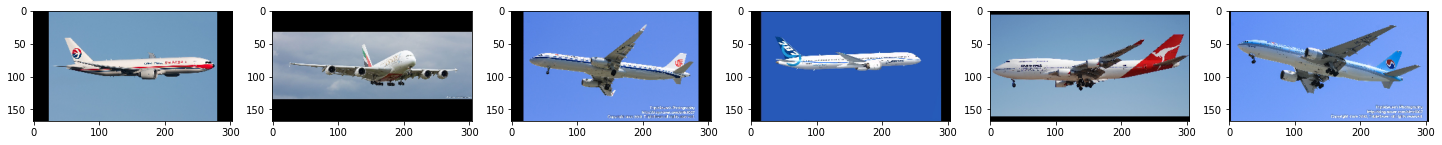

In [ ]:
n = 6                                          # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) # Создаем полотно из n графиков
for i in range(n):                             # Выводим в цикле n случайных изображений
    img = random.choice(images_airplane)       # Выбираем случайное фото для отображения
    axs[i].imshow(img)                         # Отображаем фото
plt.show()                                     # Показываем изображения

In [ ]:
segments_airplane = []                                     # Создаем пустой список для хранений сегментированных изображений обучающей выборки

cur_time = time.time()                                     # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'Segment')): # Проходим по всем файлам в каталоге по указанному пути     
    segments_airplane.append(image.load_img(os.path.join(directory + 'Segment',filename),
                                       target_size=(img_width, img_height)))                 # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 21.466365575790405c


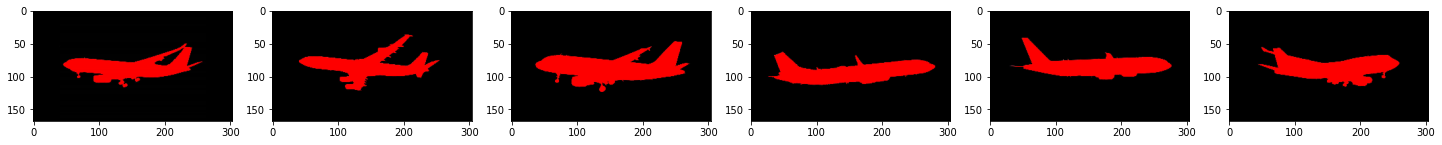

In [ ]:
n =6                                           # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) # Создаем полотно из n графиков
for i in range(n):                             # Выводим в цикле n случайных изображений
  img = random.choice(segments_airplane)       # Выбираем случайное фото для отображения
  axs[i].imshow(img)                           # Отображаем фото
plt.show()                                     # Показываем изображения

## Создание выборки



In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index  

In [ ]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # фон
    elif index == 1:
        color = [255, 0, 0]  # самолет
    return color 

In [ ]:
# Функция перевода индекса пикселя в to_categorical
def rgbToohe(y, num_classes): 
    y_shape = y.shape                         # Запоминаем форму массива для решейпа
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
    yt = []                                   # Создаем пустой лист
    for i in range(len(y)):                   # Проходим по всем трем канала изображения
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
    yt = np.array(yt)                         # Преобразуем в numpy
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру
    return yt                                 # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
    yTrain = []                               # Создаем пустой список под карты сегметации
    for seg in data:                          # Пробегаем по всем файлам набора с сегминтированными изображениями
        y = image.img_to_array(seg)           # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = rgbToohe(y, num_classes)          # Получаем OHE-представление сформированного массива
        yTrain.append(y)                      # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0:            # Каждые 100 шагов
            print(len(yTrain))                # Выводим количество обработанных изображений
    return np.array(yTrain)                   # Возвращаем сформированный yTrain

In [ ]:
xTrain = []                                   # Создаем пустой список под обучающую выборку
for img in images_airplane: 
    x = image.img_to_array(img)               # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x)                          # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain)                     # Переводим в numpy
print(xTrain.shape)                           # Размерность обучающей выборки

(1000, 168, 304, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(segments_airplane, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100
200
300
400
500
600
700
800
900
1000
Время обработки:  783.13 c


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [ ]:
y_train.shape

(900, 170, 320, 2)

## Обучение модели

### Функция создания сети PSP-Net 

In [ ]:
'''
  Функция создания сети PSP-Net 
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def pspnet(num_classes = 3, input_shape= (100, 200, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape
    
    # Начало
    x = Conv2D(32, (3, 3), padding='same', name='start')(img_input)        # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # Ветка 1
    x1        = Conv2D(32, (3, 3), padding='same', name='line1_conv1')(x)  # Добавляем Conv2D-слой с 32-нейронами
    x1        = BatchNormalization()(x1)                                   # Добавляем слой BatchNormalization
    x1        = Activation('relu')(x1)                                     # Добавляем слой Activation
    x1        = MaxPooling2D(strides=2)(x1)                                         # Добавляем слой MaxPooling2D
    x1        = Conv2D(32, (3, 3), padding='same', name='line1_conv2')(x1) # Добавляем Conv2D-слой с 32-нейронами
    x1        = BatchNormalization()(x1)                                   # Добавляем слой BatchNormalization
    x1        = Activation('relu')(x1)                                     # Добавляем слой Activation
    x1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x1)   # Добавляем слой Conv2DTranspose с 32 нейронами
    x1        = BatchNormalization()(x1)                                   # Добавляем слой BatchNormalization
    x1        = Activation('relu')(x1)                                     # Добавляем слой Activation

    # Ветка 2
    x2        = Conv2D(32, (3, 3), padding='same', name='line2_conv1')(x)        # Добавляем Conv2D-слой с 32-нейронами
    x2        = BatchNormalization()(x2)                                   # Добавляем слой BatchNormalization
    x2        = Activation('relu')(x2)                                     # Добавляем слой Activation
    x2        = MaxPooling2D(strides=4)(x2)                                         # Добавляем слой MaxPooling2D
    x2        = Conv2D(32, (3, 3), padding='same', name='line2_conv2')(x2) # Добавляем Conv2D-слой с 32-нейронами
    x2        = BatchNormalization()(x2)                                   # Добавляем слой BatchNormalization
    x2        = Activation('relu')(x2)                                     # Добавляем слой Activation
    x2 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same')(x2)   # Добавляем слой Conv2DTranspose с 32 нейронами
    x2        = BatchNormalization()(x2)                                   # Добавляем слой BatchNormalization
    x2        = Activation('relu')(x2)                                     # Добавляем слой Activation

    # Ветка 3
    x3        = Conv2D(32, (3, 3), padding='same', name='line3_conv1')(x)  # Добавляем Conv2D-слой с 32-нейронами
    x3        = BatchNormalization()(x3)                                   # Добавляем слой BatchNormalization
    x3        = Activation('relu')(x3)                                     # Добавляем слой Activation
    x3        = MaxPooling2D(strides=8)(x3)                                         # Добавляем слой MaxPooling2D
    x3        = Conv2D(32, (3, 3), padding='same', name='line3_conv2')(x3) # Добавляем Conv2D-слой с 32-нейронами
    x3        = BatchNormalization()(x3)                                   # Добавляем слой BatchNormalization
    x3        = Activation('relu')(x3)                                     # Добавляем слой Activation
    x3 = Conv2DTranspose(32, (2, 2), strides=(8, 8), padding='same')(x3)   # Добавляем слой Conv2DTranspose с 32 нейронами
    x3        = BatchNormalization()(x3)                                   # Добавляем слой BatchNormalization
    x3        = Activation('relu')(x3)                                     # Добавляем слой Activation

    # Объединяем ветки
    x_conc    = concatenate([x1, x2, x3])
    x_conc     = Conv2D(32, (3, 3), padding='same', name='line_conc')(x_conc)  # Добавляем Conv2D-слой с 32-нейронами
    x_conc     = BatchNormalization()(x_conc)                               # Добавляем слой BatchNormalization
    x_conc     = Activation('relu')(x_conc)                                 # Добавляем слой Activation

    x_out = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x_conc)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    modelp = Model(img_input, x_out) # Создаем модель с входом 'img_input' и выходом 'x_out'
    
    # Компилируем модель 
    modelp.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return modelp # Возвращаем сформированную модель


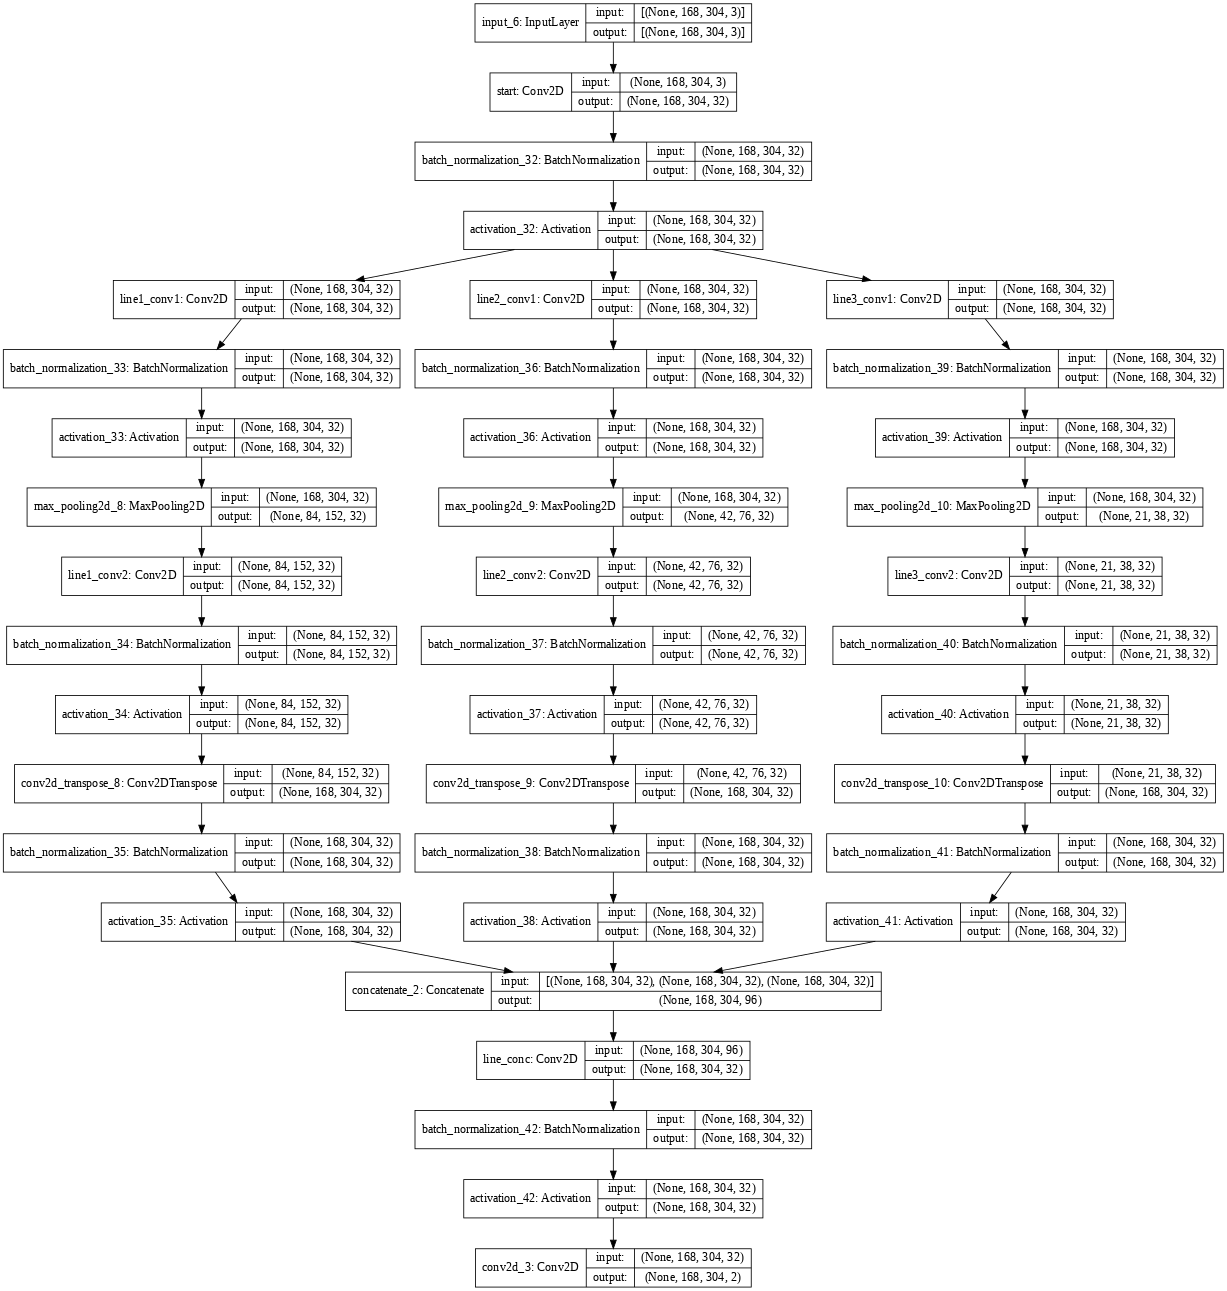

In [ ]:
modelPlane = pspnet(2, (img_width, img_height,3))
utils.plot_model(modelPlane, dpi=60, show_shapes=True)


In [ ]:
history = modelPlane.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_val, y_val)) # Обучаем модель на выборке по трем классам

Epoch 1/35
57/57 [==============================] - 57s 440ms/step - loss: 0.1532 - dice_coef: 0.9049 - val_loss: 0.3302 - val_dice_coef: 0.7476
Epoch 2/35
57/57 [==============================] - 24s 414ms/step - loss: 0.0958 - dice_coef: 0.9462 - val_loss: 0.3013 - val_dice_coef: 0.8188
Epoch 3/35
57/57 [==============================] - 24s 414ms/step - loss: 0.0818 - dice_coef: 0.9544 - val_loss: 0.2271 - val_dice_coef: 0.8928
Epoch 4/35
57/57 [==============================] - 24s 415ms/step - loss: 0.0807 - dice_coef: 0.9548 - val_loss: 0.1069 - val_dice_coef: 0.9291
Epoch 5/35
57/57 [==============================] - 24s 414ms/step - loss: 0.0765 - dice_coef: 0.9580 - val_loss: 0.0809 - val_dice_coef: 0.9477
Epoch 6/35
57/57 [==============================] - 24s 414ms/step - loss: 0.0698 - dice_coef: 0.9613 - val_loss: 0.1240 - val_dice_coef: 0.9411
Epoch 7/35
57/57 [==============================] - 24s 414ms/step - loss: 0.0750 - dice_coef: 0.9592 - val_loss: 0.0709 - val_dic

In [ ]:
 modelPlane.save_weights('/content/drive/MyDrive/Предобученные сети/Сегментация/modelPlane.h5')

## Распознавание



In [ ]:
modelPlane = pspnet(2, (img_width, img_height,3))
modelPlane.load_weights('/content/drive/MyDrive/Предобученные сети/Сегментация/modelPlane.h5')

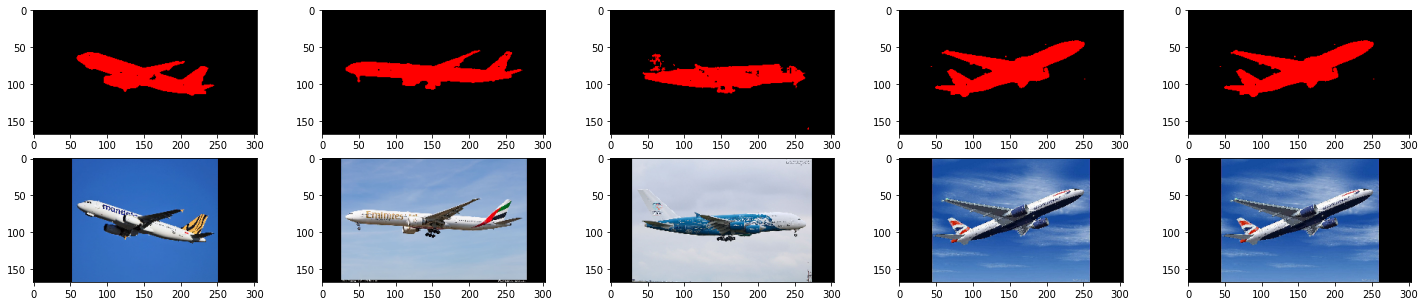

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count)                                         # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5))                                        #Создаем полотно из n графиков
for i,idx in enumerate(indexes):                                                          # Проходим по всем сгенерированным индексам
    predict = np.array(modelPlane.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картинку
    pr = predict[0]                                                                       # Берем нулевой элемент из перидкта
    pr1 = []                                                                              # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes)                                                        # Решейпим предикт
    for k in range(len(pr)):                                                              # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k]))                                                    # Переводим индекс в пиксель
    pr1 = np.array(pr1)                                                                   # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3)                                            # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8'))                                            # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA'))                                                  # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8')))                          # Отображаем на графике во второй линии оригинальное изображение        
plt.show() 

# Наложение маски

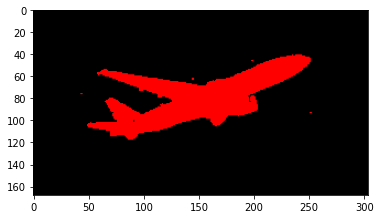

In [ ]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)

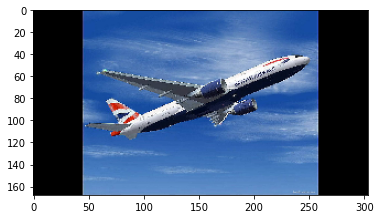

In [ ]:
plt.imshow(Image.fromarray(x_val[idx].astype('uint8')))

In [ ]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [0, 150, 0, 150]

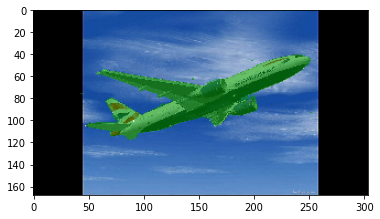

In [ ]:
img2 = Image.fromarray(x_val[idx].astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')
img2.paste(img, (0, 0),img)
plt.imshow(img2)